# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



First we load the data

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

# 1. Define Party Colors (Based on standard Danish political colors)
party_colors = {
    'Socialdemokratiet': '#b31518',       # A (Red)
    'Venstre': '#0f85ca',                 # V (Blue)
    'Moderaterne': '#800080',             # M (Purple)
    'Socialistisk Folkeparti': '#d61a5e', # F (Red/Pink)
    'Danmarksdemokraterne': '#004d99',    # D (Dark Blue)
    'Nye Borgerlige': '#005599',          # D (Similar Dark Blue)
    'Liberal Alliance': '#ef852d',        # I (Orange)
    'Det Konservative Folkeparti': '#00583c', # C (Green)
    'Enhedslisten': '#7e1e36',            # Æ (Red-Green)
    'Radikale Venstre': '#e6007e',        # B (Magenta)
    'Alternativet': '#00ff00',            # Z (Bright Green)
    'Dansk Folkeparti': '#dfba08',        # O (Yellow)
    'Frie Grønne, Danmarks Nye Venstrefløjsparti': '#32cd32', # G (Green)
    'Kristendemokraterne': '#f6b12d',     # K (Orange/Yellow)
    'Løsgænger': '#808080'                # Independents (Grey)
}

try:
    # Loading alldata.xlsx as it contains responses from both stations
    df = pd.read_excel('alldata.xlsx')
    print("Data loaded successfully.")
    print(f"Shape: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print("File not found. Please check the path.")

Data loaded successfully.
Shape: (867, 53)


,530,531,533,534,535,537,538,540,541,543,...,9a,9b,10a,10b,11a,11b,12a,12b,storkreds,alder
0,-1,-2,1,-2,2,1,-2,1,1,2,...,2,0,1,-2,-2,1,1,1,Københavns Storkreds,78
1,2,2,-1,-2,-1,-2,1,-2,2,-2,...,-2,0,-1,2,1,-2,0,0,Fyns Storkreds,64
2,2,1,-2,-2,1,-2,1,-1,1,-1,...,-1,-2,0,2,0,-1,1,-2,Bornholms Storkreds,37
3,2,1,-2,-1,1,1,1,1,1,-2,...,-2,2,2,2,2,-1,2,0,Nordjyllands Storkreds,28
4,1,1,-2,2,-2,1,-2,1,2,-2,...,-2,0,-1,0,-2,0,2,-2,Københavns Storkreds,58


Now we will proceed with the preprocecssing of the data 

In [10]:
metadata_cols = ['parti', 'navn', 'storkreds'] # Adjust these names based on actual column headers
metadata_cols = [col for col in metadata_cols if col in df.columns]

question_cols = [col for col in df.columns if col not in metadata_cols]

print(f"Metadata columns identified: {metadata_cols}")
print(f"Number of question columns: {len(question_cols)}")

#Now we create features based on the answers to the questions
X = df[question_cols]

# Filling with 0 implies a 'Neutral' stance for missing answers, which is safer than dropping for this specific dataset structure
X_filled = X.fillna(0)

# Using StandardScaler because the data is interval-like (-2 to 2) and we want to normalize variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)

print("Data scaled successfully.")

Metadata columns identified: ['parti', 'navn', 'storkreds']
Number of question columns: 50
Data scaled successfully.


Since we have many questions that would equal plenty of dimentions, but since we want to visualize the political landcape in 2D, we need to perform dimensionality reduction 

Explained Variance: PC1 = 40.91%, PC2 = 10.08%


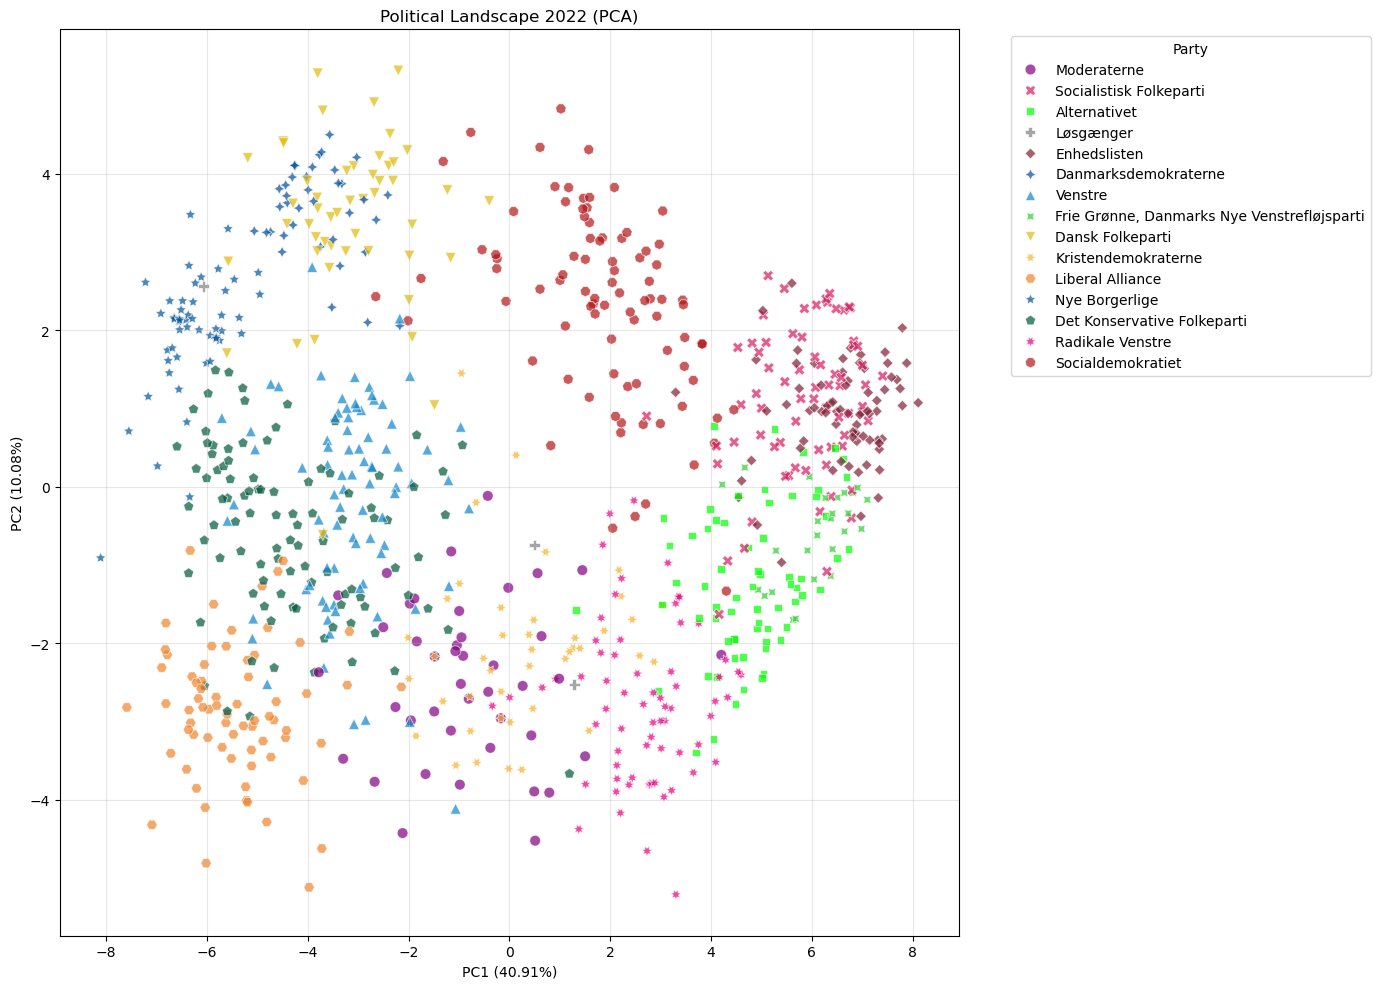

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
df_pca = df.copy()
df_pca['PC1'] = X_pca[:, 0]
df_pca['PC2'] = X_pca[:, 1]

# Calculate explained variance
var_ratio = pca.explained_variance_ratio_
print(f"Explained Variance: PC1 = {var_ratio[0]:.2%}, PC2 = {var_ratio[1]:.2%}")

# Plotting the Political Landscape
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=df_pca, 
    x='PC1', 
    y='PC2', 
    hue='parti', 
    palette=party_colors,
    style='parti', # Different shapes for different parties can help distinguish them
    alpha=0.7,
    s=60
)
plt.title('Political Landscape 2022 (PCA)')
plt.xlabel(f'PC1 ({var_ratio[0]:.2%})')
plt.ylabel(f'PC2 ({var_ratio[1]:.2%})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Party')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

=== TOP QUESTIONS DEFINING PC1 (X-axis) ===
530    0.190643
537    0.190213
4a     0.188772
3b     0.188750
550    0.188521
531    0.187010
543    0.185881
559    0.176250
548    0.176216
540    0.174384
Name: PC1, dtype: float64

=== TOP QUESTIONS DEFINING PC2 (Y-axis) ===
10b    0.302771
556    0.297671
551    0.293191
553    0.273748
4b     0.257564
5a     0.227888
6a     0.207800
6b     0.207330
555    0.206355
534    0.199945
Name: PC2, dtype: float64


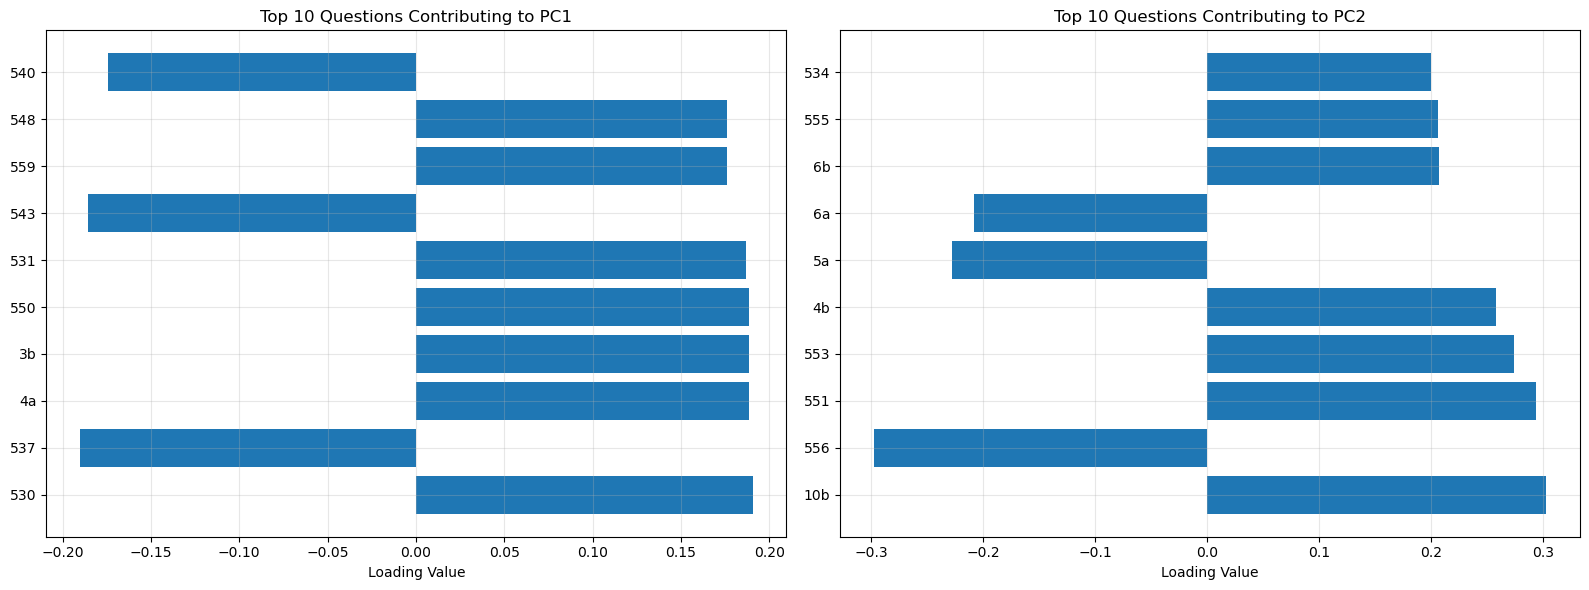

In [12]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=question_cols)

print("=== TOP QUESTIONS DEFINING PC1 (X-axis) ===")
print(loadings['PC1'].abs().sort_values(ascending=False).head(10))

print("\n=== TOP QUESTIONS DEFINING PC2 (Y-axis) ===")
print(loadings['PC2'].abs().sort_values(ascending=False).head(10))

# Visualize loadings
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PC1 loadings
top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(10)
axes[0].barh(range(len(top_pc1)), loadings.loc[top_pc1.index, 'PC1'])
axes[0].set_yticks(range(len(top_pc1)))
axes[0].set_yticklabels(top_pc1.index)
axes[0].set_xlabel('Loading Value')
axes[0].set_title('Top 10 Questions Contributing to PC1')
axes[0].grid(True, alpha=0.3)

# PC2 loadings
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(10)
axes[1].barh(range(len(top_pc2)), loadings.loc[top_pc2.index, 'PC2'])
axes[1].set_yticks(range(len(top_pc2)))
axes[1].set_yticklabels(top_pc2.index)
axes[1].set_xlabel('Loading Value')
axes[1].set_title('Top 10 Questions Contributing to PC2')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== PARTY AVERAGES (First 5 Questions) ===
                                                  530       531       533  \
parti                                                                       
Alternativet                                 1.880597  1.134328 -1.895522   
Danmarksdemokraterne                        -0.837838 -1.378378  1.513514   
Dansk Folkeparti                            -0.571429 -1.081633  1.551020   
Det Konservative Folkeparti                 -0.836735 -1.877551  0.948980   
Enhedslisten                                 1.959459  1.864865 -1.918919   
Frie Grønne, Danmarks Nye Venstrefløjsparti  1.923077  1.923077 -2.000000   
Kristendemokraterne                          0.880952 -0.666667 -1.285714   
Liberal Alliance                            -1.142857 -1.971429 -0.857143   
Løsgænger                                    0.000000 -0.666667 -0.333333   
Moderaterne                                  0.642857  0.904762 -0.285714   
Nye Borgerlige                   

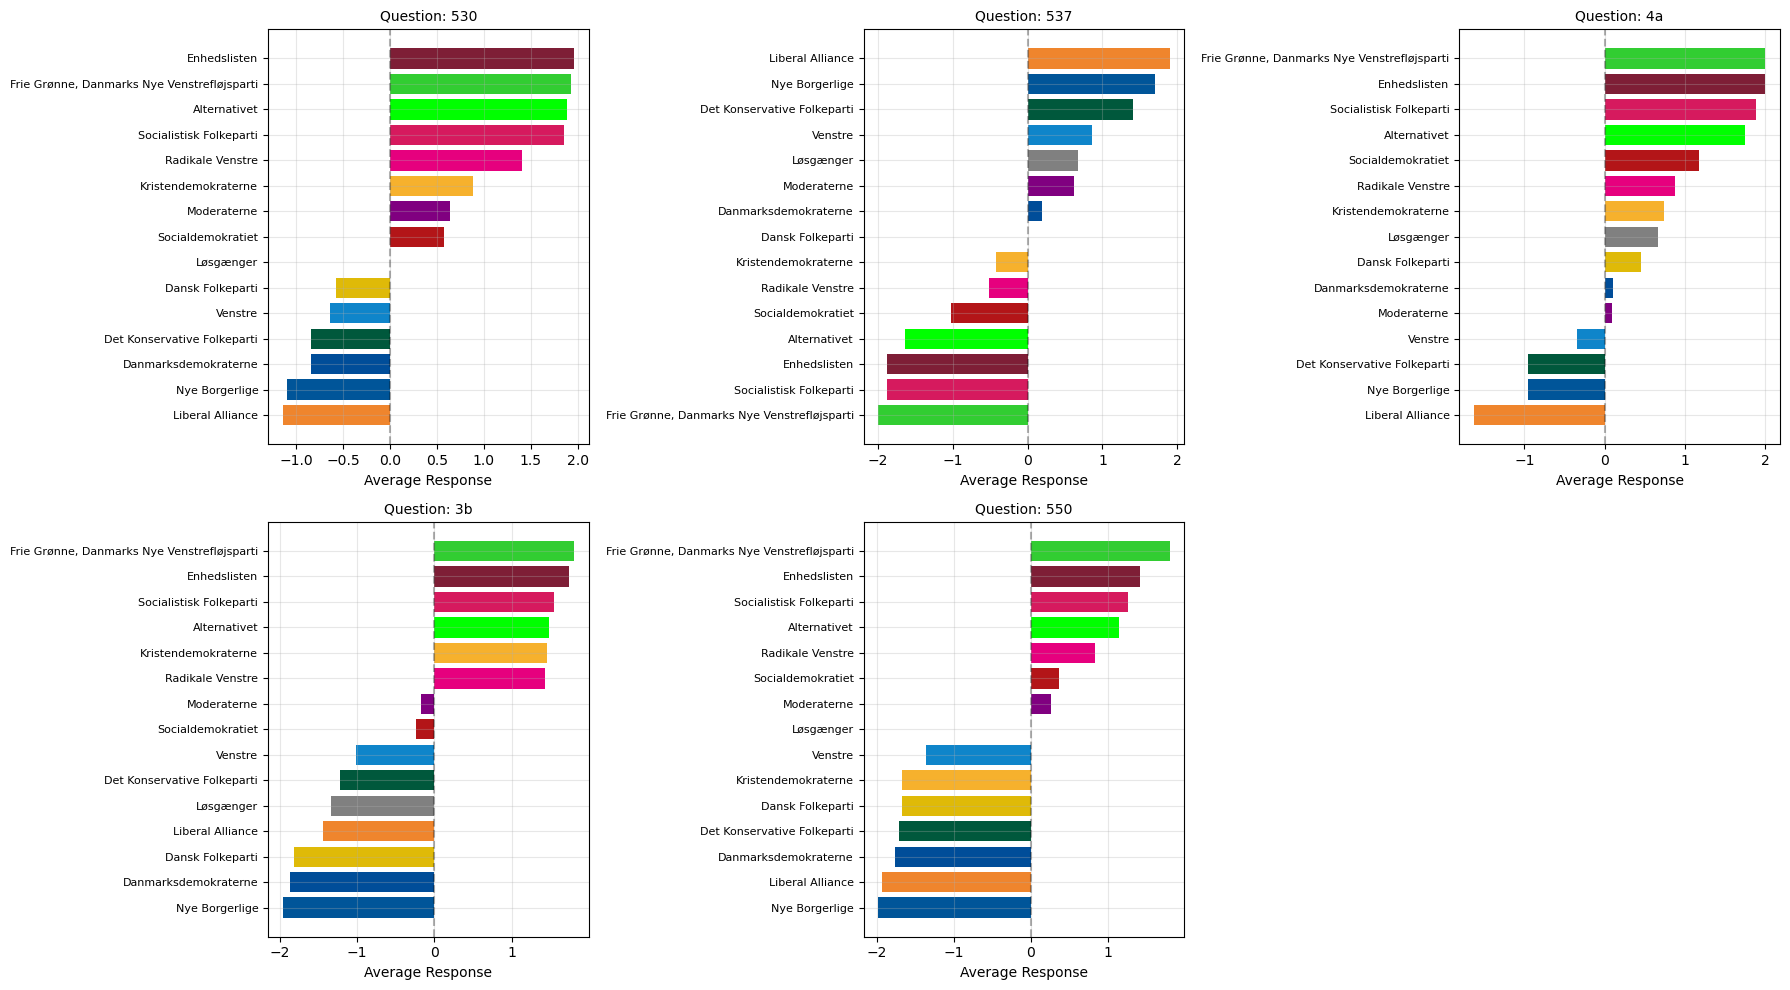

In [13]:
party_averages = df.groupby('parti')[question_cols].mean()

print("=== PARTY AVERAGES (First 5 Questions) ===")
print(party_averages.iloc[:, :5])

# Visualize party positions for top questions from PCA
top_questions = loadings['PC1'].abs().sort_values(ascending=False).head(5).index

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, question in enumerate(top_questions):
    party_avg = df.groupby('parti')[question].mean().sort_values()
    colors = [party_colors.get(party, '#808080') for party in party_avg.index]
    
    axes[i].barh(range(len(party_avg)), party_avg.values, color=colors)
    axes[i].set_yticks(range(len(party_avg)))
    axes[i].set_yticklabels(party_avg.index, fontsize=8)
    axes[i].set_xlabel('Average Response')
    axes[i].set_title(f'Question: {question}', fontsize=10)
    axes[i].axvline(x=0, color='black', linestyle='--', alpha=0.3)
    axes[i].grid(True, alpha=0.3)

# Remove extra subplot
axes[-1].remove()

plt.tight_layout()
plt.show()

Now that we have prepared the data we can proceed with the clustering analysis 

=== K-MEANS CLUSTERING ANALYSIS ===


c:\Users\sergi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\sergi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\sergi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\sergi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

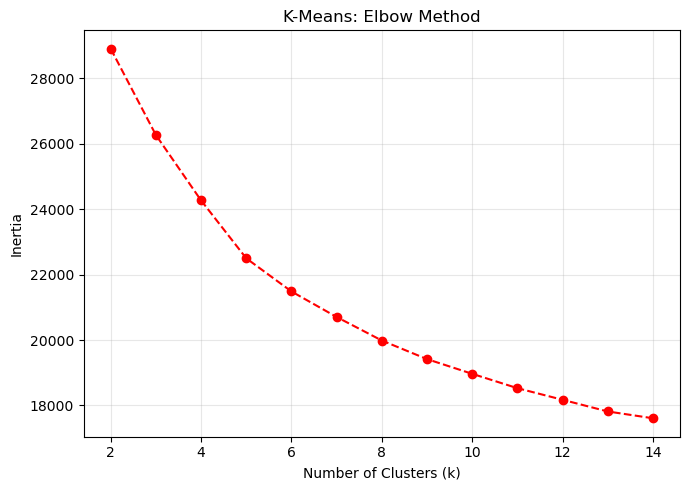

In [17]:
print("=== K-MEANS CLUSTERING ANALYSIS ===")

k_range = range(2, 15)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot evaluation metrics
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

# Elbow Method
axes.plot(k_range, inertias, marker='o', linestyle='--', color='red')
axes.set_xlabel('Number of Clusters (k)')
axes.set_ylabel('Inertia')
axes.set_title('K-Means: Elbow Method')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

c:\Users\sergi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(



Optimal K selected: 5
Silhouette Score: 0.165


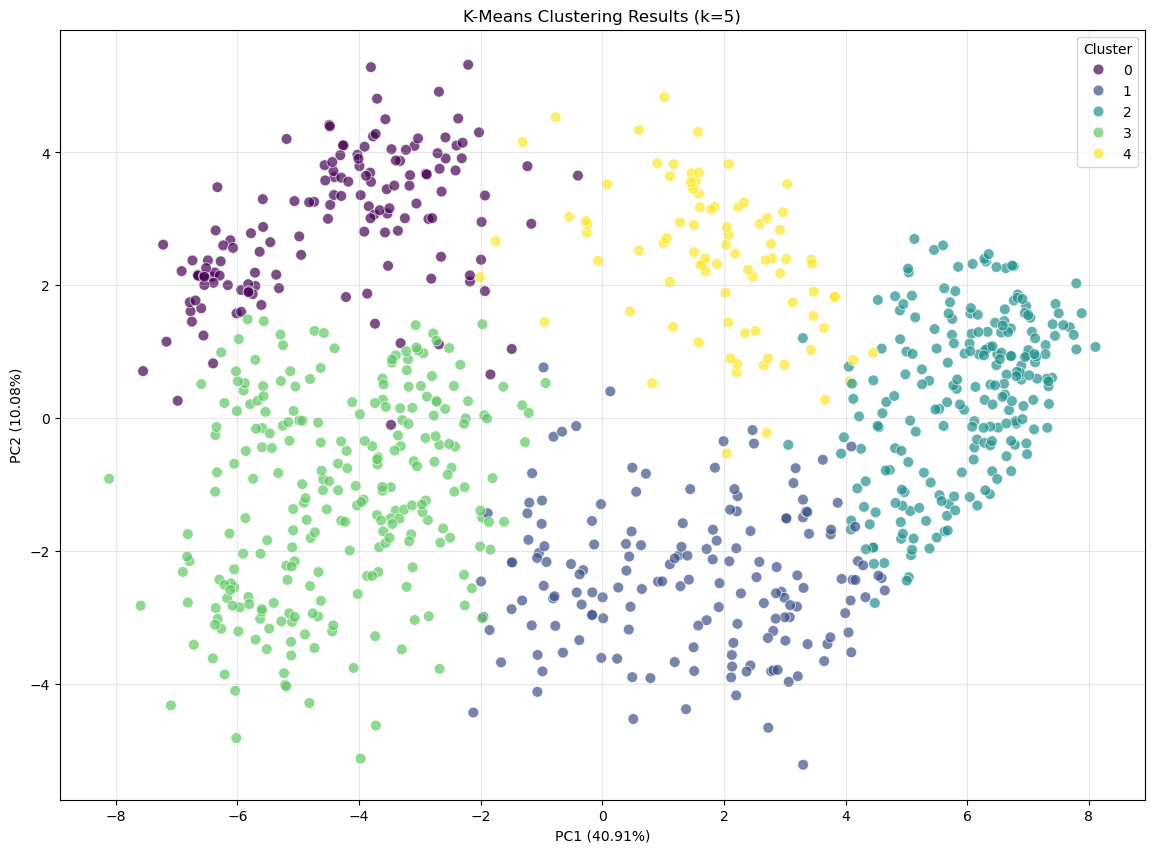


=== K-Means Cluster vs. Party Cross-Tabulation ===
parti           Alternativet  Danmarksdemokraterne  Dansk Folkeparti  \
kmeans_cluster                                                         
0                          0                    37                48   
1                         14                     0                 0   
2                         53                     0                 0   
3                          0                     0                 1   
4                          0                     0                 0   

parti           Det Konservative Folkeparti  Enhedslisten  \
kmeans_cluster                                              
0                                         1             0   
1                                         2             0   
2                                         0            74   
3                                        95             0   
4                                         0             0   

parti          

In [18]:
optimal_k = 5  #  based on elbow method
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_pca['kmeans_cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"\nOptimal K selected: {optimal_k}")
print(f"Silhouette Score: {silhouette_score(X_scaled, df_pca['kmeans_cluster']):.3f}")

# Visualize K-Means results
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=df_pca, 
    x='PC1', 
    y='PC2', 
    hue='kmeans_cluster', 
    palette='viridis',
    s=60,
    alpha=0.7
)
plt.title(f'K-Means Clustering Results (k={optimal_k})')
plt.xlabel(f'PC1 ({var_ratio[0]:.2%})')
plt.ylabel(f'PC2 ({var_ratio[1]:.2%})')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

# Cross-tabulate clusters with actual parties
print("\n=== K-Means Cluster vs. Party Cross-Tabulation ===")
cluster_party_table = pd.crosstab(df_pca['kmeans_cluster'], df_pca['parti'])
print(cluster_party_table)


=== HIERARCHICAL CLUSTERING ANALYSIS ===


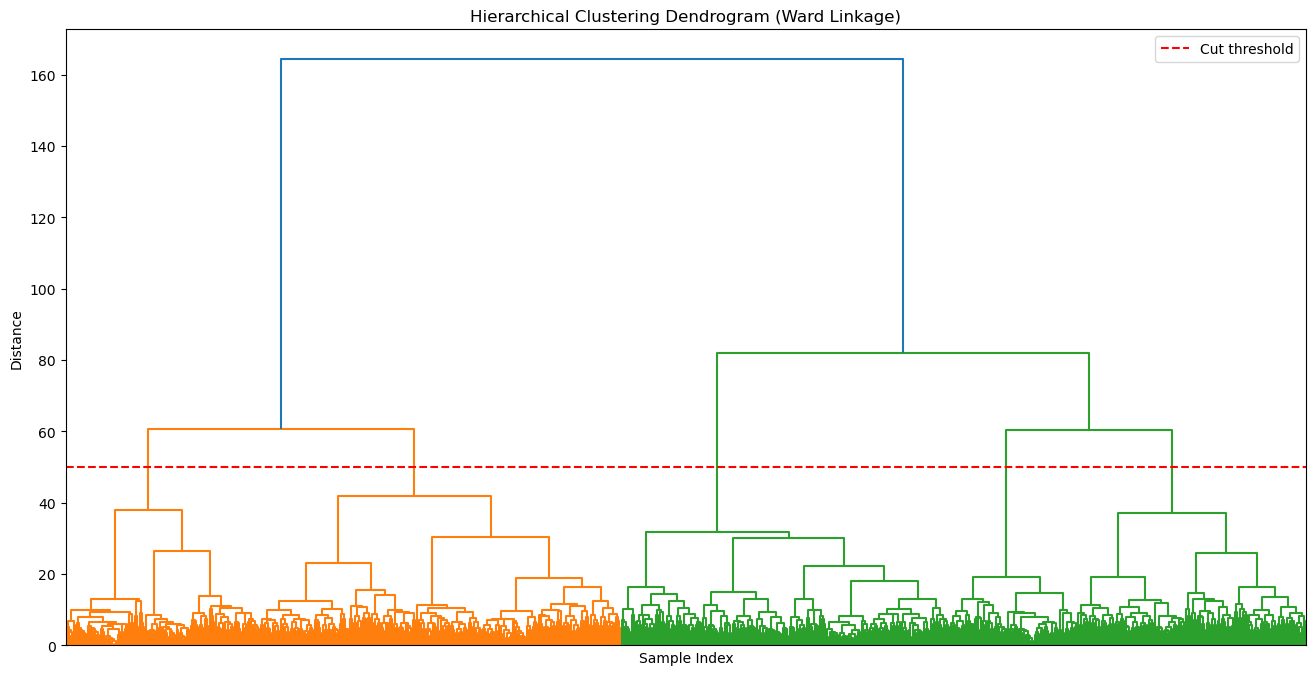

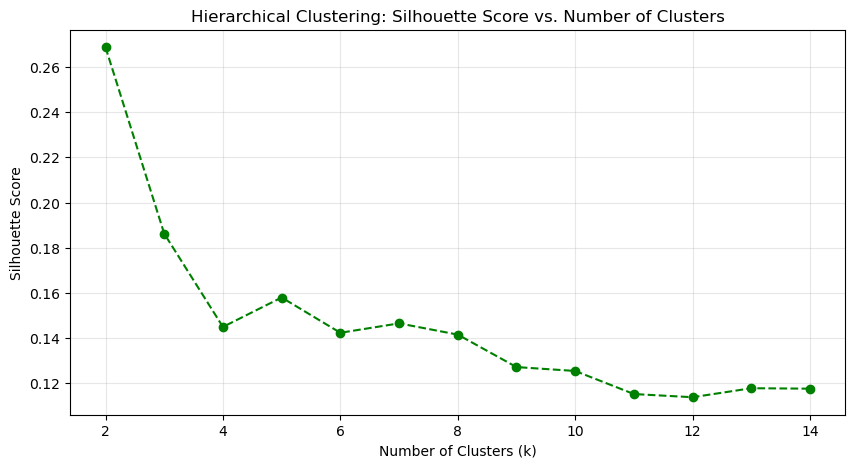

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

print("\n=== HIERARCHICAL CLUSTERING ANALYSIS ===")

# Create linkage matrix using Ward's method
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, no_labels=True)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=50, color='r', linestyle='--', label='Cut threshold')
plt.legend()
plt.show()

# Fit Agglomerative Clustering with different numbers of clusters

silhouette_scores_agg = []
k_range_agg = range(2, 15)

for k in k_range_agg:
    agg_cluster = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg_cluster.fit_predict(X_scaled)
    silhouette_scores_agg.append(silhouette_score(X_scaled, labels))

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(k_range_agg, silhouette_scores_agg, marker='o', linestyle='--', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Hierarchical Clustering: Silhouette Score vs. Number of Clusters')
plt.grid(True, alpha=0.3)
plt.show()
